In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

## Useful websites

- https://www.nytimes.com/interactive/2014/upshot/buy-rent-calculator.html

- https://smartasset.com/mortgage/rent-vs-buy

# TODO

Job market opportunities

Expected home price at end

Other investment opportunities

ARIMA model for price prediction

Super deep net!!!

https://machinelearningmastery.com/multi-step-time-series-forecasting/

In [4]:
class Mortgate():
    def __init__(self,
                 house_cost,
                 down_payment,
                 interest=.05,
                 years=30,
                 points=0,
                 yearly_property_insurance=1200,
                 rent=1000,
                 monthly_HOA = 0,
                 sqft = 2000,
                 extra_monthly_pay=0
                ):
        self.house_cost = house_cost
        self.principal = house_cost - down_payment
        self.years = years
        self.yearly_property_insurance = yearly_property_insurance
        self.down_payment = down_payment
        self.months = self.years*12
        self.interest_rate = interest
        self.yearly_costs = None
        self.DF = self.build_DF()
        self.rent = rent
        self.hoa = monthly_HOA
        self.sqft = sqft

    def build_DF(self):
        df = pd.DataFrame(index=self._datetime_domain())
        princ, inter = self.payment_arrays()
        df['Principal'] = princ
        df['Interest'] = inter
        debt, equi = self.eq_deb_arr()
        df['Debt'] = debt
        df['Equity'] = equi
        return df
    
    def total_mortgage(self):
        return self.monthly_mortgage()*self.months
    
    
    def monthly_mortgage(self, normal=True):
        '''
        Computes monthly payment for just the mortgage to pay it
        in the number of years desired
        
        Returns
        -------
            int: monthly mortgage payment
        '''
        if normal==True:
            principal=self.principal
        else:
            principal=normal
        r = self.interest_rate/12
        N = self.months
        monthly = r*principal*(1+r)**N/((1+r)**N-1)
        return monthly
    
    
    def monthly_non_mortgage(self, list_stuff):
        return 0 
    
    
    def monthly_mortgage_related(self):
        if self.yearly_costs == None:
            self.added_yearly_costs()
            
        yearly_mort_related = sum(self.yearly_costs)
        monthly_mort_related = yearly_mort_related/12.
        
        return monthly_mort_related
    
    
    def total_monthly(self):
        tots_month = self.monthly_mortgage()
        tots_month += self.monthly_non_mortgage()
        tots_month += self.monthly_mortgage_related()
        return tots_month
    
    def closing_costs(self):
        '''
        
        Returns
        -------
            total : Total amount payed when paying the whole house
        '''
        return 0
    
    def total_payment(self, others=[]):
        '''
        
        Returns
        -------
            total : Total amount payed when paying the whole house
        '''
        total = self.total_mortgage()
        total += self.closing_costs() + self.down_payment
        return total
    
    def monthly_non_investment(self, normal=True, inter=None):
        '''
        Calculates how much you would pay each month in things that are
        not building equity (e.g. interest, insurance, repairs, etc.)
        Returns
        -------
            monthly_cost : array, non-investment payments
        '''
        if normal==True:
            _, interest = self.payment_arrays()
        else:
            interest = inter
        yearly_mort_related = sum(self.yearly_costs[:4])
        monthly_mort_related = yearly_mort_related/12.
        
        return interest+monthly_mort_related
    
    def added_yearly_costs(self, other_tags=[]):
        '''
        
        Returns
        -------
            added_costs : list of all other costs
        '''
        if self.down_payment/self.house_cost >= .2:
            cost_amounts = [self.house_cost*.0075,
                            0,
                            self.yearly_property_insurance,
                            self.house_cost*.01,
                            self.hoa*12
                           ]
        else:
            cost_amounts = [self.house_cost*.0075,
                            0.01*self.principal,
                            self.yearly_property_insurance,
                            self.sqft,
                            self.hoa*12
                           ]
            
        cost_tags = [
            'annual_tax',
            'annual_mortgage_insurance',
            'annual_property_insurance',
            'annual_home_repairs'
            'annual_hoa'
        ]
        
        for cost in other_tags:
            amount = input('How much' + cost + 'will you pay a year?')
            cost_amounts.append(amount)

        self.yearly_costs = np.array(cost_amounts)

    
    def payment_arrays(self, normal=True, tuplet=(0,0)):
        '''
        Creates two arrays showing how principal and interest are payed
        every month for the whole extent of the mortgage.
        
        Returns
        -------
            principal : array
            interest : array
        '''
        if normal==True:
            asd = self.monthly_mortgage()
            prin = self.principal
            
        else:
            asd, prin = tuplet
            
        principal = []
        interest_ = []
        r = self.interest_rate/12
        
        for i in range(self.months):
            int_paid = prin*r
            princ_paid = asd - int_paid
            prin -= princ_paid
            principal.append(princ_paid)
            interest_.append(int_paid)
        return np.array(principal), np.array(interest_)
    
    
    def eq_deb_arr(self):
        '''
        Creates two arrays showing the equity build and the debt to pay
        every month for the whole extent of the mortgage.
        
        Returns
        -------
            principal : array
            interest : array
        '''
        asd = self.monthly_mortgage()
        debt = []
        equity = []
        prin = self.principal
        r = self.interest_rate/12
        
        for i in range(self.months):
            int_paid = prin*r
            princ_paid = asd - int_paid
            prin -= princ_paid
            debt.append(int_paid)
            equity.append(princ_paid)
        return np.array(debt), np.array(equity)

    
    def _datetime_domain(self):
        numdays = 300
        base = dt.datetime.today()
        date_list = [base + relativedelta(months=x) for x in range(self.months)]
        return date_list
        
        
    def plot_split(self):
        '''
        '''
        with plt.xkcd():
            plt.figure(figsize=(15,12))
            plt.title('Principal VS Interest', fontsize=18)
            self.DF.Principal.plot(label = 'Principal Paid')
            self.DF.Interest.plot(label = 'Interest Paid')
            plt.legend(loc='best')
            plt.show()

    
    def __str__(self):
        out = '============================\n      Mortgage SUMMARY\n============================\n'
        out += f'House Cost:       {self.house_cost:10.2f}' + '\n'
        out += f'Down Payment:     {self.down_payment:10.2f}' + '\n'
        out += f'Interest Paid:    {self.DF.Interest.sum():10.2f}' + '\n'
        out += f'Total Cost:       {self.total_payment():10.2f}' + '\n'
        out += f'Monthly Mortgage: {self.monthly_mortgage():10.2f}' + '\n'
        out += f'Monthly Own Costs:{self.monthly_mortgage()+self.monthly_mortgage_related():10.2f}' + '\n'
        end = self.DF.index[-1]
        out += f'Done Paying By:   {end:%Y-%m-%d}' + '\n'
        '''Job market opportunities'''
        '''Expected home price at end'''
        '''Other investment opportunities'''
        return out

    
    def debt_equity(self):
        '''
        '''
        with plt.xkcd():
            plt.figure(figsize=(15,12))
            plt.title('Debt VS Equity', fontsize=14)
            self.DF.Debt.plot(label = 'Debt Owed')
            self.DF.Equity.plot(label = 'Equity Built')
            plt.legend(loc='best')
            plt.show()
            
    def rent_down(self):
        '''
        Implement comparison of renting for longer
        and save for down payment vs buy now and pay
        bigger payment
        '''
        # So far it just makes savings predictions upon continuing
        # the current expenditure rate. A lot of work to do.
        savings = 14500
        ren = self.rent
        inf = .02
        ren_inc = .02
        month_save = 5000
        savings_array = {}    
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        for i in range(361):
            if i%12==0 and i!=0:
                ren*=1+ren_inc
                month_save = month_save*1.03
            if i==22:
                month_save -= 3000
            savings+=month_save
            savings_array[f'{months[int((i+11)%12)]} {2018+(i+11)//12}'] = savings
        return(savings_array)
    
    
    def alternative_downpayments(self):
        '''
        print: Graph showing alternatives
        
        Returns
        -------
            opt_down : Optimum down payment percentage
            tot_paym : Total amount payed over time
        '''
        # TODO: Devaluation over the years
        # TODO: Cost of renting during saving time
        totals = []
        unbroken = True
        for down in range(0, self.house_cost, 1000):
            # Recalculate the principal and the monthly pay
            principal = self.house_cost - down
            monthly = self.monthly_mortgage(normal=principal)
            
            total_from_months = monthly*self.months
            totals.append(total_from_months+down)
            
            _, interest_array = self.payment_arrays(normal=False, tuplet=(monthly,principal))
            non_invest = self.monthly_non_investment(False,interest_array)
            if non_invest[0]<self.rent and unbroken:
                print(f'Braking point at a down payment of ${down}')
                unbroken = False
        plt.plot(list(range(0, self.house_cost, 1000)),totals)
        plt.show()
        return totals

In [5]:
example = Mortgate(300000, 60000, 0.04, 30, monthly_HOA=100)

In [6]:
print(example)

      Mortgage SUMMARY
House Cost:        300000.00
Down Payment:       60000.00
Interest Paid:     172486.82
Total Cost:        472486.82
Monthly Mortgage:    1145.80
Monthly Own Costs:   1783.30
Done Paying By:   2049-03-29



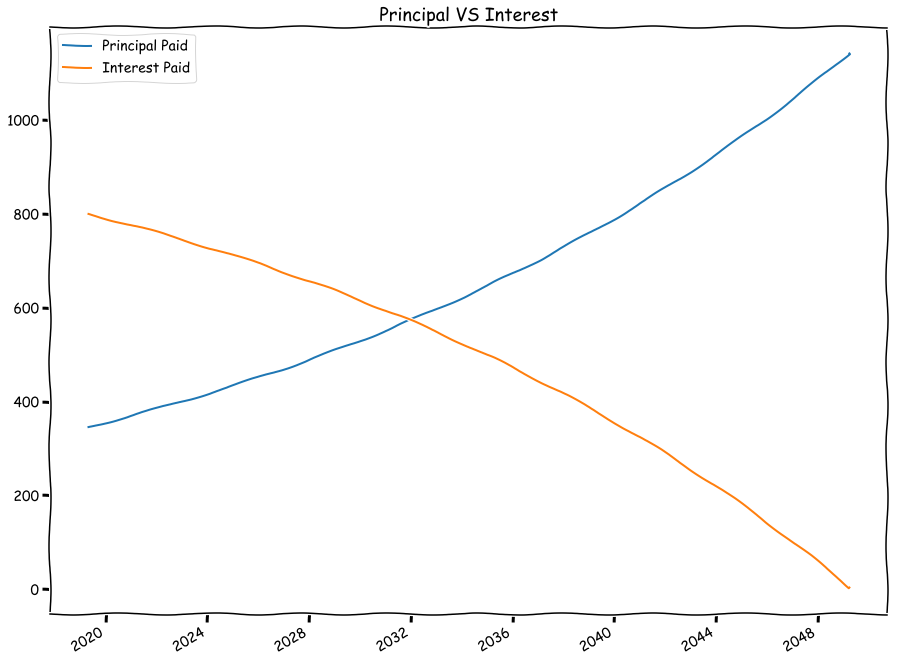

In [8]:
example.plot_split()

# What would give us a higher net? 
If we put 1000 extra a month, or if we invest those 1000?